# Data Mining Project - Touristic Hotspot in Lyon


## Import Library

In [1]:
! pip3 install numpy==1.26.0 
! pip3 install pandas==2.1.1 
! pip3 install scikit-learn==1.5.1 
! pip3 install scipy==1.12.0
! pip3 install plotly==5.24.1 
! pip3 install matplotlib==3.8.0 
! pip3 install seaborn==0.13.2 
! pip3 install plotly-express==0.4.1 
! pip3 install chart-studio==1.1.0 
! pip3 install streamlit==1.37.1 
! pip3 install mlxtend==0.23.3 
! pip3 install nltk

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial import ConvexHull

import os
import webbrowser
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Cleaning Data

In [3]:
import pandas as pd
import numpy as np

# Charger le dataset
data = pd.read_csv("../data/dataset.csv", sep=",", low_memory=False)
print(f"Dimensions initiales : {data.shape}")

# Nettoyer les noms de colonnes
data.columns = data.columns.str.strip()

# Supprimer les colonnes Unnamed créées à cause d'un mauvais formatage
data = data.drop(columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18"], errors='ignore')
# Supprimer les colonnes inutiles
data = data.drop(columns=["date_upload_minute", "date_upload_hour", "date_upload_day", "date_upload_month","date_upload_year"])
#Supprimer les lignes qui n'ont ni tags, ni titre
data = data.dropna(subset=['tags', 'title'], how='all')

# Supprimer les doublons
data = data.drop_duplicates(keep='first')
print(f"Après suppression des doublons : {data.shape}")

# Supprimer les lignes qui n'ont ni tags ni titre
data = data.dropna(subset=['tags', 'title'], how='all')

# Fonction pour normaliser les dates mal formatées
def normalize_date(year, month, day, hour, minute):
    try:
        return pd.to_datetime(f"{int(year)}-{int(month)}-{int(day)} {int(hour)}:{int(minute)}", errors='coerce')
    except ValueError:
        return np.nan  # Remplace les dates invalides par NaN

# Appliquer la normalisation des dates
data['date_taken'] = data.apply(
    lambda row: normalize_date(row['date_taken_year'], row['date_taken_month'], row['date_taken_day'],
                               row['date_taken_hour'], row['date_taken_minute']), axis=1)

# Supprimer les lignes avec des dates invalides
data = data.dropna(subset=['date_taken'])
data = data.drop(columns=["date_taken_minute", "date_taken_hour", "date_taken_day", "date_taken_month", "date_taken_year"])

print(f"Après correction et suppression des dates invalides : {data.shape}")

# Filtrage géographique (Lyon)
validation_rules = {
    'lat': lambda x: pd.api.types.is_number(x) and 45.614067767464974 <= x <= 45.88380569722158,
    'long': lambda x: pd.api.types.is_number(x) and 4.655505238288724 <= x <= 5.042868327562071,
}

# Nettoyage des coordonnées géographiques
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')
data['long'] = pd.to_numeric(data['long'], errors='coerce')
data = data.dropna(subset=['lat', 'long'])

print(f"Après suppression des lignes hors format : {data.shape}")

# Sauvegarde
data.to_csv('../data/datasetCleaned.csv', index=False)
print("Sauvegarde des données dans 'data/datasetCleaned.csv'")


Dimensions initiales : (420240, 19)
Après suppression des doublons : (157967, 11)
Après correction et suppression des dates invalides : (157917, 7)
Après suppression des lignes hors format : (157917, 7)
Sauvegarde des données dans 'data/datasetCleaned.csv'


In [14]:
data_path = "../data/datasetCleaned.csv"
df = pd.read_csv(data_path, low_memory=False)

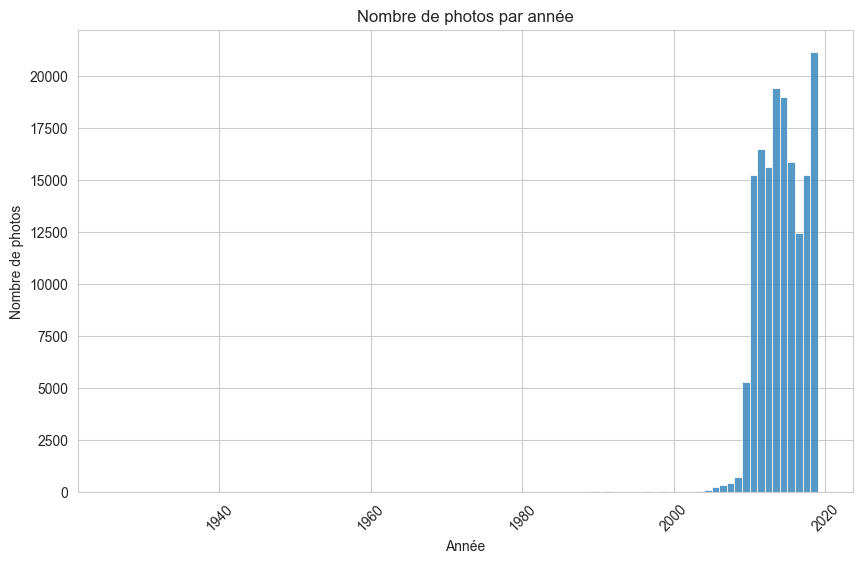

In [15]:
data = pd.read_csv("../data/datasetCleaned.csv", parse_dates=['date_taken'])

# Ajuster la taille des graphiques
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

# Histogramme du nombre de photos par année
plt.figure()
data['year'] = data['date_taken'].dt.year
sns.histplot(data['year'], bins=range(data['year'].min(), data['year'].max() + 1), kde=False)
plt.title("Nombre de photos par année")
plt.xlabel("Année")
plt.ylabel("Nombre de photos")
plt.xticks(rotation=45)
plt.show()

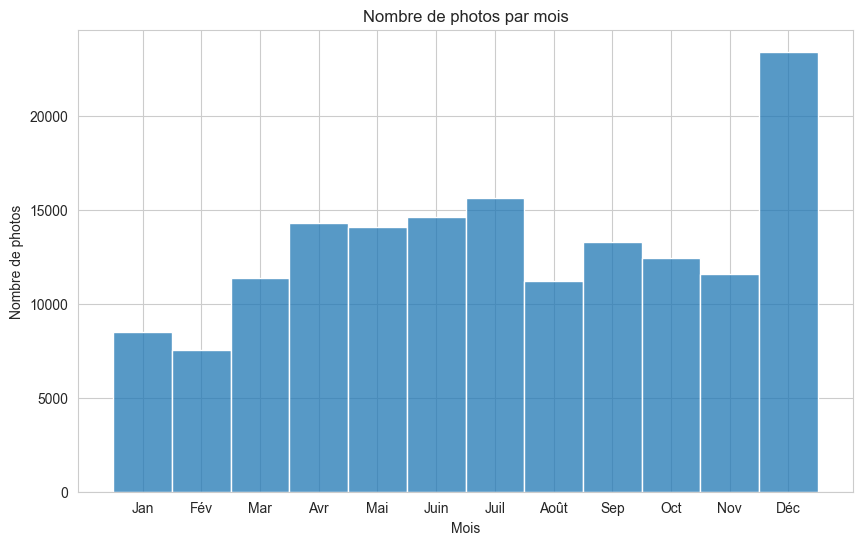

In [16]:
# Histogramme du nombre de photos par mois
plt.figure()
data['month'] = data['date_taken'].dt.month
sns.histplot(data['month'], bins=12, kde=False, discrete=True)
plt.title("Nombre de photos par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de photos")
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.show()

/var/folders/fk/_hwth5xs3mx2mqbv_9vhvypm0000gn/T/ipykernel_4440/2041846839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  december_data['day'] = december_data['date_taken'].dt.day


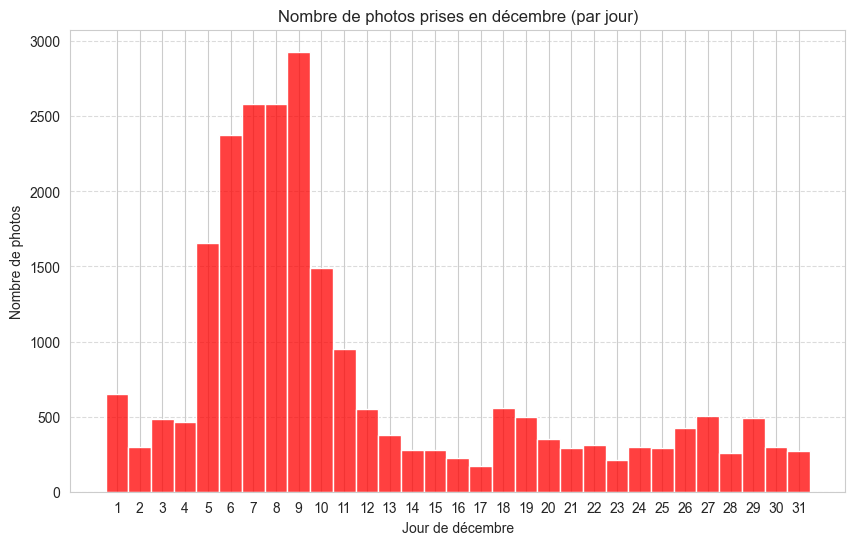

In [17]:
december_data = data[data['date_taken'].dt.month == 12]

plt.figure(figsize=(10, 6))
december_data['day'] = december_data['date_taken'].dt.day
sns.histplot(december_data['day'], bins=31, kde=False, discrete=True, color='red')
plt.title("Nombre de photos prises en décembre (par jour)")
plt.xlabel("Jour de décembre")
plt.ylabel("Nombre de photos")
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

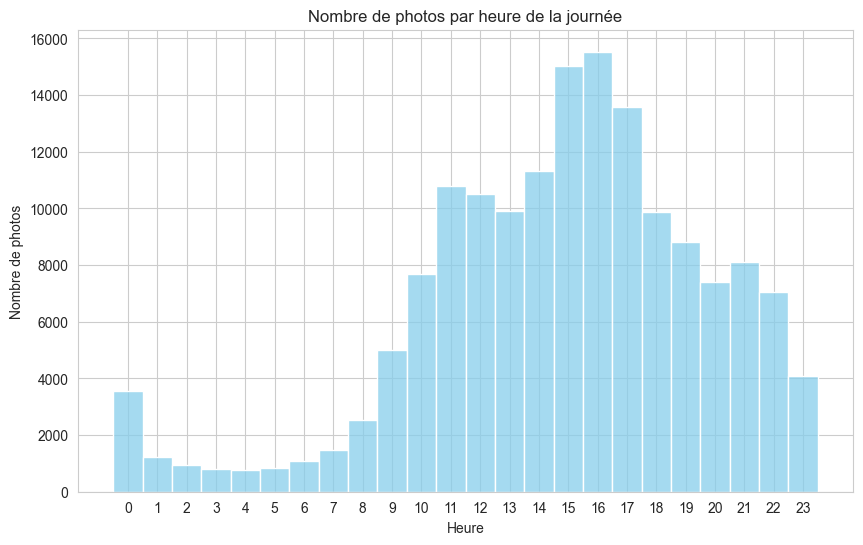

In [18]:

# Histogramme du nombre de photos par heure de la journée
plt.figure()
data['hour'] = data['date_taken'].dt.hour
sns.histplot(data['hour'], bins=24, kde=False, discrete=True, color='skyblue')
plt.title("Nombre de photos par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Nombre de photos")
plt.xticks(range(0, 24))
plt.show()

/var/folders/fk/_hwth5xs3mx2mqbv_9vhvypm0000gn/T/ipykernel_4440/2278771630.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette="viridis")


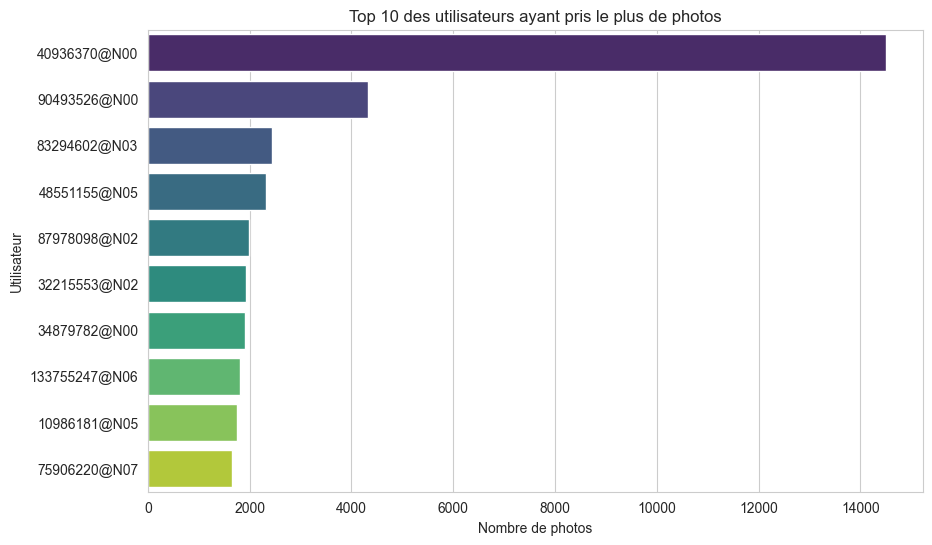

In [19]:
# Top 10 des utilisateurs avec le plus de photos
plt.figure()
top_users = data['user'].value_counts().head(10)
sns.barplot(x=top_users.values, y=top_users.index, palette="viridis")
plt.title("Top 10 des utilisateurs ayant pris le plus de photos")
plt.xlabel("Nombre de photos")
plt.ylabel("Utilisateur")
plt.show()

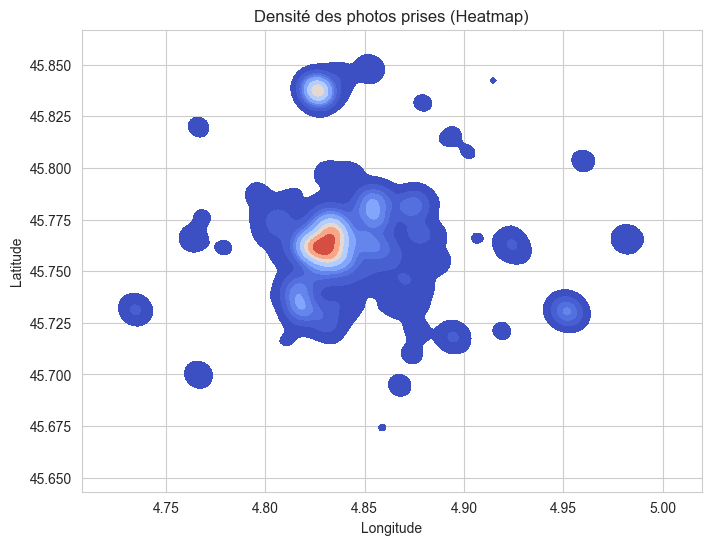

In [20]:
# Carte de densité des photos (Heatmap 2D)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=data['long'], y=data['lat'], cmap="coolwarm", fill=True)
plt.title("Densité des photos prises (Heatmap)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 2. Discovering areas of interests using clustering
### 2.1. KMeans Clustering

In [21]:
print("Chargement des données...")
data_path = "../data/datasetCleaned.csv"
df = pd.read_csv(data_path, low_memory=False)
print("Données chargées")

Chargement des données...
Données chargées


In [22]:
dfKMeans = df
print("Application de K-Means...")
X = dfKMeans[['lat', 'long']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
dfKMeans['cluster'] = kmeans.fit_predict(X_scaled)
print(f"K-Means terminé avec {len(set(dfKMeans['cluster']))} clusters")

# Create Folium map
print("Creation de la carte folium...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate colors for clusters
cluster_colors = [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(len(dfKMeans['cluster'].unique()))
]

# Add points to map
for _, row in dfKMeans.iterrows():
    cluster_id = row['cluster']
    color = cluster_colors[cluster_id]
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(map_clusters)
    
# Save and open the map
map_file = "../output/clusteringKMeans.html"
map_clusters.save(map_file)
print(f"Carte sauvegardé dans {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Carte prête")

Application de K-Means...
K-Means terminé avec 50 clusters
Creation de la carte folium...
Carte sauvegardé dans ../output/clusteringKMeans.html
Carte prête


### 2.2. Hierarchical Clustering

In [23]:
dfHierarchical = df

# Reduce density by random sampling (keep only 20% of points)
dfHierarchical = dfHierarchical.sample(frac=0.2, random_state=42)
print(f"Taille des données après échantillonnage: {len(dfHierarchical)} points")

# Apply Hierarchical Clustering
print("Application de Hierarchical Clustering...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfHierarchical[['lat', 'long']])

n_clusters = 25
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
dfHierarchical['cluster'] = clustering.fit_predict(X_scaled)
print(f"Clustering terminée avec {n_clusters} clusters")

# Create Folium map
print("Creation de la carte folium...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate unique colors for each cluster
cluster_colors = [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(len(dfHierarchical['cluster'].unique()))
]

# Add cluster points
for _, row in dfHierarchical.iterrows():
    cluster_id = row['cluster']
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=5,
        color=cluster_colors[cluster_id],
        fill=True,
        fill_opacity=0.5,
        popup=f"Cluster {cluster_id}"
    ).add_to(map_clusters)

# Save and open the map
map_file = "../output/clustersHierarchical.html"
map_clusters.save(map_file)
print(f"Carte sauvegardé dans {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Carte prête")

Taille des données après échantillonnage: 31583 points
Application de Hierarchical Clustering...
Clustering terminée avec 25 clusters
Creation de la carte folium...
Carte sauvegardé dans ../output/clustersHierarchical.html
Carte prête


### 2.3 DBSCAN Clustering

In [24]:
dfDBSCAN = df

# Sampling to improve performance (reduce density)
dfDBSCAN = dfDBSCAN.sample(frac=0.1, random_state=42)  # Keep only 5% of points
print(f"Taille des données après échantillonnage: {len(dfDBSCAN)} points")

# Apply DBSCAN clustering
print("Application de DBSCAN...")
X = dfDBSCAN[['lat', 'long']].values

eps = 0.0002
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dfDBSCAN['cluster'] = dbscan.fit_predict(X)

# Compute cluster statistics
n_clusters = len(set(dfDBSCAN['cluster'])) - (1 if -1 in dfDBSCAN['cluster'] else 0)
n_noise = sum(dfDBSCAN['cluster'] == -1)
print(f"Clustering terminée avec: {n_clusters} clusters")
print(f"Clustering terminée avec: {n_noise} noise points")

# Create Folium map
print("Creation de la carte folium...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate unique colors for each cluster
cluster_colors = ['#808080']  # Gray for noise points
cluster_colors += [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(n_clusters)
]

# Add cluster points
for _, row in dfDBSCAN.iterrows():
    cluster_id = row['cluster']
    color_idx = cluster_id + 1 if cluster_id >= 0 else 0  # Gray for noise
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color=cluster_colors[color_idx],
        stroke=False if cluster_id < 0 else True,
        fill=True,
        fill_opacity=0.5 if cluster_id >= 0 else 0.6
    ).add_to(map_clusters)

cluster_centroids = {}

# Add convex hulls for clusters
# Add convex hulls for clusters
for cluster_id in range(n_clusters):
    cluster_points = dfDBSCAN[dfDBSCAN['cluster'] == cluster_id][['lat', 'long']].values
    unique_points = np.unique(cluster_points, axis=0)  # Éliminer les points en double

    if len(unique_points) >= 3:  # Un polygone nécessite au moins 3 points distincts
        try:
            hull = ConvexHull(unique_points)
            hull_points = unique_points[hull.vertices]

            # Calculer le centroïde du cluster (moyenne des points du hull)
            centroid_lat = np.mean(hull_points[:, 0])
            centroid_long = np.mean(hull_points[:, 1])
            cluster_centroids[cluster_id] = (centroid_lat, centroid_long)  # Stocker les coordonnées

            # Ajouter le polygone sur la carte
            folium.Polygon(
                locations=[[point[0], point[1]] for point in hull_points],
                color=cluster_colors[cluster_id + 1],
                weight=2,
                fill=True,
                fill_color=cluster_colors[cluster_id + 1],
                fill_opacity=0.2
            ).add_to(map_clusters)

        except Exception as e:
            print(f"Error creating polygon for cluster {cluster_id}: {e}")

# Save and open the map
map_file = "../output/clusteringDBSCAN.html"
map_clusters.save(map_file)
print(f"Carte sauvegardé dans {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Carte prête")

Taille des données après échantillonnage: 15792 points
Application de DBSCAN...
Clustering terminée avec: 161 clusters
Clustering terminée avec: 7267 noise points
Creation de la carte folium...
Carte sauvegardé dans ../output/clusteringDBSCAN.html
Carte prête


### Sauvegarde du meilleurs clustering dans un fichiers csv

In [25]:
bestClustering = dfDBSCAN

clustered_csv_path = "../output/clusteredData.csv"
bestClustering.to_csv(clustered_csv_path, index=False)
print(f"Données clusterisée sauvegardé dans :{clustered_csv_path}")

Données clusterisée sauvegardé dans :../output/clusteredData.csv


## 3. Description of areas of interest using text pattern mining

### 3.1. Load data

In [28]:
# Charger le dataset contenant les tags
data_path = "../output/clusteredData.csv"
dfTP = pd.read_csv(data_path, low_memory=False)

# Afficher quelques tags bruts
dfTP[['tags', 'title']].head(10)


,tags,title
0,"cactus,plante,lyon",IMG_9844
1,"froid,partdieu,gratteciel,pollution,hiver,mati...",Pollution sur lyon
2,"dalbera,ben,magasin,lyon,muséedartcontemporain...",Le Bizart Baz'art de Ben (musée d'art contempo...
3,"lyon,full,moon,city",Harvest Moon
4,NaN,Cosplay Disney Show
5,"france,line,ligne,courbe,curve,géométrie,geome...",Grille épaisse
6,"square,squareformat,perpetua,iphoneography,ins...",Ça va doser large #sfv #retro
7,"streetart,france,pasteup,collage,paper,europe,...","Pasted paper by Quetzilla [Lyon, France]"
8,69,"Lyon (Rhône), basilique St-Martin d'Ainay (45)"
9,"lyon,basilica",Mosaic


### 3.2. Stopwords in french and english

In [29]:
stop_words = set(stopwords.words('french') + stopwords.words('english'))

# Initialisation du lemmatiseur
lemmatizer = WordNetLemmatizer()

def clean_text(text, stop_words):
    if pd.isna(text):  # Gérer les valeurs manquantes
        return ""

    # Conversion en minuscules
    text = text.lower()

    # Remplace les virgules par des espaces pour éviter que les mots ne collent ensemble
    text = text.replace(",", " ")

    # Suppression des autres caractères spéciaux et chiffres (mais conserver les espaces)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Tokenisation
    words = word_tokenize(text)

    # Suppression des stopwords et lemmatisation
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Reconstruction du texte
    return " ".join(words).strip()

# Nettoyer les titres et tags
dfTP['cleaned_title'] = dfTP['title'].fillna('').apply(lambda x: clean_text(x, stop_words))
dfTP['cleaned_tags'] = dfTP['tags'].fillna('').apply(lambda x: clean_text(x, stop_words))

# Afficher les résultats après nettoyage
dfTP[['cleaned_title', 'cleaned_tags']].head(10)



,cleaned_title,cleaned_tags
0,img,cactus plante lyon
1,pollution lyon,froid partdieu gratteciel pollution hiver mati...
2,bizart bazart ben musée dart contemporain lyon,dalbera ben magasin lyon muséedartcontemporain...
3,harvest moon,lyon full moon city
4,cosplay disney show,
5,grille épaisse,france line ligne courbe curve géométrie geome...
6,ça va doser large sfv retro,square squareformat perpetua iphoneography ins...
7,pasted paper quetzilla lyon france,streetart france pasteup collage paper europe ...
8,lyon rhône basilique stmartin dainay,
9,mosaic,lyon basilica


### 3.3. Lemmatisation

In [30]:
lemmatizer = WordNetLemmatizer()

# Applique la lemmatisation à un texte nettoyé.
def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

# Appliquer la lemmatisation
dfTP['lemmatized_title'] = dfTP['cleaned_title'].apply(lemmatize_text)
dfTP['lemmatized_tags'] = dfTP['cleaned_tags'].apply(lemmatize_text)

# Afficher les résultats après lemmatisation
dfTP[['lemmatized_title', 'lemmatized_tags']].head(10)


,lemmatized_title,lemmatized_tags
0,img,cactus plante lyon
1,pollution lyon,froid partdieu gratteciel pollution hiver mati...
2,bizart bazart ben musée dart contemporain lyon,dalbera ben magasin lyon muséedartcontemporain...
3,harvest moon,lyon full moon city
4,cosplay disney show,
5,grille épaisse,france line ligne courbe curve géométrie geome...
6,ça va doser large sfv retro,square squareformat perpetua iphoneography ins...
7,pasted paper quetzilla lyon france,streetart france pasteup collage paper europe ...
8,lyon rhône basilique stmartin dainay,
9,mosaic,lyon basilica


### 3.4. Wordcloud

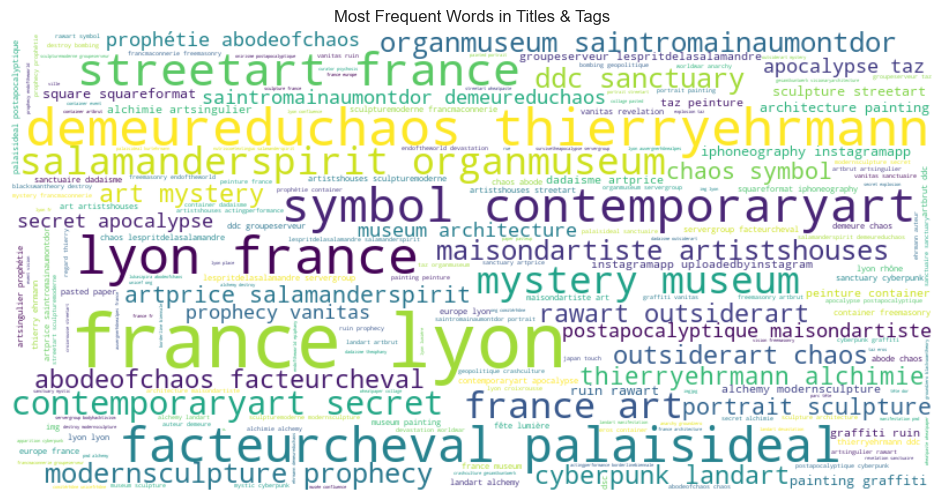

In [31]:
# Concaténer tous les titres et tags
all_text = " ".join(dfTP['lemmatized_title'].dropna()) + " " + " ".join(dfTP['lemmatized_tags'].dropna())

# Générer le Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Afficher le Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Titles & Tags")
plt.show()


In [ ]:
# Exclure les clusters bruités (-1)
dfTP = dfTP[dfTP['cluster'] != -1]

# Fusionner les colonnes de texte
dfTP['combined_text'] = dfTP['cleaned_title'].fillna('') + " " + dfTP['cleaned_tags'].fillna('')

# Regrouper les textes par cluster
cluster_texts = dfTP.groupby('cluster')['combined_text'].apply(lambda x: ' '.join(x)).reset_index()

# Définir une liste de mots à exclure (stopwords spécifiques au dataset)
excluded_words = {"lyon", "france", "image", "img", "photo", "flickr", "city", "picture", "rhône", "alpes",
                  "ville", "tourism", "urban", "travel", "place", "dsc", "dor", "imgjpg", "fr", "sec", "iphoneography",
                  "uploadedbyinstagram", "instagramapp", "instagram", "frankreich", "rhônealpes", "auvergnerhônealpes",
                  "frankrijk", "francia", "frança"}

# Fonction pour extraire les mots-clés principaux d'un cluster
def extract_keywords(text, top_n=5):
    words = text.split()
    word_counts = Counter(words)
    
    # Filtrer les mots exclus
    filtered_counts = {word: count for word, count in word_counts.items() if word not in excluded_words}
    
    # Trier et récupérer les top mots les plus fréquents
    top_keywords = [word for word, _ in Counter(filtered_counts).most_common(top_n)]
    
    return ", ".join(top_keywords) if top_keywords else "Cluster sans nom"

# Appliquer la fonction aux clusters
cluster_texts['cluster_name'] = cluster_texts['combined_text'].apply(lambda text: extract_keywords(text, top_n=5))

# Convertir en dictionnaire (Cluster ID -> Nom)
cluster_keywords = dict(zip(cluster_texts['cluster'], cluster_texts['cluster_name']))

# Afficher les résultats
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {keywords}")


Cluster 0: parcdelatêtedor, cactus, serre, parc, tête
Cluster 1: fourvière, basilique, fourviere, notredame, basilica
Cluster 2: cosplay, japan, touch, japactu, japactuinfo
Cluster 3: croixrousse, zombie, walk, europe, rooftop
Cluster 4: basilique, dainay, roman, saintmartin, stmartin
Cluster 5: bellecour, lumières, placebellecour, europe, fête
Cluster 6: croixrousse, zombie, europe, pasted, paper
Cluster 7: ddc, chaos, demeureduchaos, abodeofchaos, thierryehrmann
Cluster 8: passage, muséedesconfluences, mdc, patrickageneau, photographie
Cluster 9: square, squareformat, foursquarevenuedebebcf, friend, upload
Cluster 10: lumières, opéra, square, squareformat, fête
Cluster 11: vieux, borgonha, frança, enseignes, rue
Cluster 12: chaos, ddc, portrait, abodeofchaos, lespritdelasalamandre
Cluster 13: terreaux, musée, placedesterreaux, beauxarts, art
Cluster 14: basketball, mono, basket, unicycle, uni
Cluster 15: palais, justice, lumières, statue, passerelle
Cluster 16: musée, gadagne, vieuxl

In [35]:
import folium

# Calculer les centroïdes des clusters
cluster_centroids = dfTP.groupby('cluster')[['lat', 'long']].mean().to_dict(orient='index')

# Ajouter les noms des clusters sur la carte
def add_cluster_names_to_map(cluster_centroids, cluster_names, map_object):
    """
    Ajoute les noms des clusters en fonction des mots-clés trouvés sur les polygones.
    """
    for cluster_id, coords in cluster_centroids.items():
        centroid_lat, centroid_long = coords['lat'], coords['long']
        name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")  # Nom du cluster

        folium.Marker(
            location=[centroid_lat, centroid_long],
            tooltip=f"<b>{name}</b>",  # Affiche le nom au survol
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_object)  # Ajout du marqueur sur le centroïde

# Appliquer la fonction sur la carte existante
add_cluster_names_to_map(cluster_centroids, cluster_keywords, map_clusters)

# Sauvegarde de la carte mise à jour
map_clusters.save("../output/clusteringDBSCAN.html")

# Ouvrir automatiquement la carte mise à jour
import webbrowser
webbrowser.open(f'file:///{os.path.abspath("../output/clusteringDBSCAN.html")}')

True

### 3.5. Removing words

In [75]:
# Liste des mots à exclure
stop_words_custom = {
    "lyon", "france", "image", "img", "photo", "flickr", "city",
    "picture", "rhône", "alpes", "ville", "tourism", "urban",
    "travel", "place", "dsc", "dor", "imgjpg", "fr", "sec", "iphoneography",
    "uploadedbyinstagram", "instagramapp", "instagram", "frankreich", "rhônealpes", "auvergnerhônealpes", "frankrijk"
}

# Combiner les titres et tags lemmatisés
dfTP['combined_text'] = dfTP['lemmatized_title'] + " " + dfTP['lemmatized_tags']

# Grouper les textes par cluster
cluster_texts = dfTP.groupby('cluster')['combined_text'].apply(lambda x: ' '.join(x)).reset_index()

# Appliquer TF-IDF
vectorizer = TfidfVectorizer(max_features=50)  # On limite à 50 mots significatifs
tfidf_matrix = vectorizer.fit_transform(cluster_texts['combined_text'])

# Récupérer les mots les plus importants pour chaque cluster
feature_names = vectorizer.get_feature_names_out()
cluster_keywords = {}

for cluster_id, row in enumerate(tfidf_matrix.toarray()):
    # Exclure les mots indésirables
    top_keywords = [feature_names[i] for i in row.argsort()[-10:][::-1] 
                    if feature_names[i] not in stop_words_custom]

    # Si tous les mots sont exclus, prendre les suivants
    if not top_keywords:
        top_keywords = [feature_names[i] for i in row.argsort()[-15:][::-1] 
                        if feature_names[i] not in stop_words_custom][:5]

    # Assigner les mots-clés au cluster
    cluster_keywords[cluster_texts.iloc[cluster_id]['cluster']] = ", ".join(top_keywords[:5])  # 5 meilleurs mots-clés

# Afficher les mots-clés par cluster
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {keywords}")


Cluster -1: europe, streetart, architecture, art, graffiti
Cluster 0: secret, vanitas, dadaisme, landart, groupeserveur
Cluster 1: europe, architecture, art, graffiti, sculpture
Cluster 2: dadaisme, lespritdelasalamandre, landart, groupeserveur, graffiti
Cluster 3: europe, portrait, streetart, architecture, dadaisme
Cluster 4: cyberpunk, landart, groupeserveur, graffiti, facteurcheval
Cluster 5: europe, museum, art, architecture, apocalypse
Cluster 6: europe, streetart, architecture, graffiti, vanitas
Cluster 7: ddc, chaos, demeureduchaos, abodeofchaos, thierryehrmann
Cluster 8: portrait, museum, europe, dadaisme, landart
Cluster 9: art, europe, dadaisme, lespritdelasalamandre, landart
Cluster 10: europe, architecture, art, sculpture, streetart
Cluster 11: graffiti, streetart, vanitas, dadaisme, landart
Cluster 12: chaos, ddc, demeureduchaos, mystery, modernsculpture
Cluster 13: art, museum, europe, sculpture, painting
Cluster 14: vanitas, dadaisme, lespritdelasalamandre, landart, grou

 ### 3.6. Adding cluster names to the map

In [78]:
def add_cluster_names_to_map(cluster_centroids, cluster_names, map_object):
    """
    Ajoute les noms des clusters en fonction des mots-clés trouvés sur les polygones.
    """
    for cluster_id, (centroid_lat, centroid_long) in cluster_centroids.items():
        name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")  # Nom du cluster

        folium.Marker(
            location=[centroid_lat, centroid_long],
            tooltip=f"<b>{name}</b>",  # Affiche le nom au survol
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_object)  # Ajout du marqueur sur le centroïde

# Appliquer la fonction sur la carte existante
add_cluster_names_to_map(cluster_centroids, cluster_keywords, map_clusters)

# Sauvegarde de la carte mise à jour
map_clusters.save("../output/clusteringDBSCAN.html")

